# EEG classifier

In [1]:
import numpy as np
import time, datetime
import matplotlib.pyplot as plt
from collections import OrderedDict

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.autograd import Variable

In [2]:
is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [3]:
import os
import pandas as pd

data_path = "../dataset/"

for dirname, _, filenames in os.walk(data_path):
    for filename in filenames:
        if "train" in filename:
            train_path = os.path.join(dirname, filename)
        if "test" in filename:
            test_path = os.path.join(dirname, filename)

In [4]:
def encode_target(target):
    if target == -55:
        return 0
    else:
        return 1

In [5]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# remove unnamed columns
train_df = train_df.iloc[: , 3:]
test_df = test_df.iloc[: , 3:]

# change target value
train_df.target = train_df.target.apply(encode_target)
test_df.target = test_df.target.apply(encode_target)

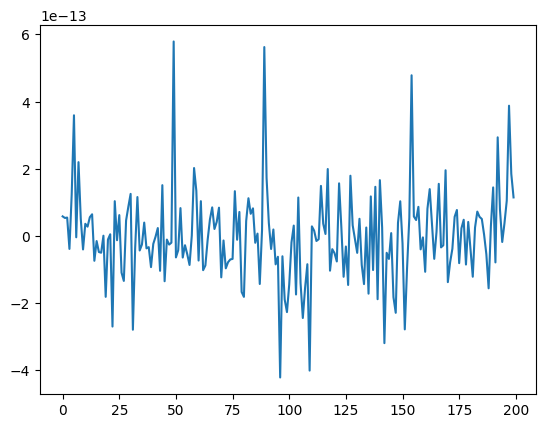

In [6]:
plt.plot(train_df.iloc[2:3, :-1].to_numpy()[0])

In [7]:
# classes
np.unique(train_df.to_numpy()[:,-1])

array([0., 1.])

In [8]:
def create_data_loader(train_df, test_df, batch_size = 100, val_split=0.3):

    # transform dataframe to numpy array
    train_data = train_df.to_numpy()
    test_data = test_df.to_numpy()
    
    # create x and y
    x_train = train_data[:, :-1]
    x_test = test_data[:, :-1]
    y_train = train_data[:, -1]
    y_test = test_data[:, -1]

    # create tensor dataset of x and y
    train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_train).float(),
                                                   torch.from_numpy(y_train).long(),)
    test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(x_test).float(),
                                                  torch.from_numpy(y_test).long())
    
    # split dataset in train, val and test
    train_len = train_data.shape[0]
    val_len = int(train_len * val_split)
    train_len -= val_len

    # shuffle train and validade data
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_len, val_len])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, val_loader, test_loader

In [11]:
batch_size = 8
val_split = 0.2

In [12]:
train_loader, val_loader, test_loader = create_data_loader(train_df, test_df, batch_size = batch_size, val_split=val_split)

In [13]:
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        
        super(RNNModel, self).__init__()
        
        # Number of hidden dimensions
        self.hidden_dim = hidden_dim
        
        # Number of hidden layers
        self.layer_dim = layer_dim
        
        # RNN
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        
        # Initialize hidden state with zeros
        h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))
            
        # One time step
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :]) 
        return out

In [15]:
n_iters = 1000 # number of iterations
num_epochs = 10 # number of training epochs

In [16]:
input_dim = 200   # input dimension
hidden_dim = 100  # hidden layer dimension
layer_dim = 10     # number of hidden layers
output_dim = 2   # output dimension

# Initiate RNN model
model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()

# SGD Optimizer
learning_rate = 0.05
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [17]:
seq_dim = 200
loss_list = []
iteration_list = []
accuracy_list = []
y_true=[]
y_pred=[]
count = 0
for epoch in range(num_epochs):
    for i, (signals, labels) in enumerate(train_loader):

        train = signals.unsqueeze(1)
        labels = labels.long()
            
        # Clear gradients
        optimizer.zero_grad()
        
        # Forward propagation
        outputs = model(train)
        
        # Calculate softmax and ross entropy loss
        loss = error(outputs, labels)
        
        # Calculating gradients
        loss.backward()
        
        # Update parameters
        optimizer.step()
        
        count += 1
        
        if count % 16 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for signals, labels in val_loader:
                signals = signals.unsqueeze(1)
                
                # Forward propagation
                outputs = model(signals)
                
                # Get predictions from the maximum value
                predicted = torch.max(outputs.data, 1)[1]
                
                # Total number of labels
                total += labels.size(0)
                
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            # store loss and iteration
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            y_true+=labels
            y_pred+=predicted
            if count % 10 == 0:
                # Print validade loss
                print('iteration: {}  val_loss: {}  val_accuracy: {} %'.format(count, loss.data, accuracy))

iteration: 1  val_loss: 0.6711229085922241  val_accuracy: 56.875 %
iteration: 2  val_loss: 0.7064179182052612  val_accuracy: 56.875 %
iteration: 3  val_loss: 0.6707783341407776  val_accuracy: 56.875 %
iteration: 4  val_loss: 0.6820658445358276  val_accuracy: 56.875 %
iteration: 5  val_loss: 0.681868851184845  val_accuracy: 56.875 %
iteration: 6  val_loss: 0.6816737651824951  val_accuracy: 56.875 %
iteration: 7  val_loss: 0.6554350256919861  val_accuracy: 56.875 %
iteration: 8  val_loss: 0.6808097958564758  val_accuracy: 56.875 %
iteration: 9  val_loss: 0.6806248426437378  val_accuracy: 56.875 %
iteration: 10  val_loss: 0.7091469168663025  val_accuracy: 56.875 %
iteration: 11  val_loss: 0.6807329654693604  val_accuracy: 56.875 %
iteration: 12  val_loss: 0.6805486679077148  val_accuracy: 56.875 %
iteration: 13  val_loss: 0.6803661584854126  val_accuracy: 56.875 %
iteration: 14  val_loss: 0.6948717832565308  val_accuracy: 56.875 %
iteration: 15  val_loss: 0.6656261086463928  val_accuracy:

iteration: 122  val_loss: 0.6705990433692932  val_accuracy: 56.875 %
iteration: 123  val_loss: 0.7298182845115662  val_accuracy: 56.875 %
iteration: 124  val_loss: 0.7583452463150024  val_accuracy: 56.875 %
iteration: 125  val_loss: 0.671167254447937  val_accuracy: 56.875 %
iteration: 126  val_loss: 0.6996780037879944  val_accuracy: 56.875 %
iteration: 127  val_loss: 0.6996140480041504  val_accuracy: 56.875 %
iteration: 128  val_loss: 0.6995506286621094  val_accuracy: 56.875 %
iteration: 129  val_loss: 0.6431229710578918  val_accuracy: 56.875 %
iteration: 130  val_loss: 0.7283667922019958  val_accuracy: 56.875 %
iteration: 131  val_loss: 0.6995007395744324  val_accuracy: 56.875 %
iteration: 132  val_loss: 0.6713659763336182  val_accuracy: 56.875 %
iteration: 133  val_loss: 0.7560016512870789  val_accuracy: 56.875 %
iteration: 134  val_loss: 0.7266650795936584  val_accuracy: 56.875 %
iteration: 135  val_loss: 0.6989860534667969  val_accuracy: 56.875 %
iteration: 136  val_loss: 0.6989288

iteration: 241  val_loss: 0.7237561941146851  val_accuracy: 56.875 %
iteration: 242  val_loss: 0.7731658816337585  val_accuracy: 56.875 %
iteration: 243  val_loss: 0.6498069167137146  val_accuracy: 56.875 %
iteration: 244  val_loss: 0.6979259848594666  val_accuracy: 56.875 %
iteration: 245  val_loss: 0.6491985321044922  val_accuracy: 56.875 %
iteration: 246  val_loss: 0.6732380986213684  val_accuracy: 56.875 %
iteration: 247  val_loss: 0.7732101678848267  val_accuracy: 56.875 %
iteration: 248  val_loss: 0.7217158079147339  val_accuracy: 56.875 %
iteration: 249  val_loss: 0.6975783705711365  val_accuracy: 56.875 %
iteration: 250  val_loss: 0.6506606340408325  val_accuracy: 56.875 %
iteration: 251  val_loss: 0.6977236270904541  val_accuracy: 56.875 %
iteration: 252  val_loss: 0.6738601922988892  val_accuracy: 56.875 %
iteration: 253  val_loss: 0.6737425327301025  val_accuracy: 56.875 %
iteration: 254  val_loss: 0.649427592754364  val_accuracy: 56.875 %
iteration: 255  val_loss: 0.7227115

iteration: 360  val_loss: 0.7242885828018188  val_accuracy: 56.875 %
iteration: 361  val_loss: 0.6982930898666382  val_accuracy: 56.875 %
iteration: 362  val_loss: 0.6224642395973206  val_accuracy: 56.875 %
iteration: 363  val_loss: 0.6725113391876221  val_accuracy: 56.875 %
iteration: 364  val_loss: 0.7248827815055847  val_accuracy: 56.875 %
iteration: 365  val_loss: 0.7242650985717773  val_accuracy: 56.875 %
iteration: 366  val_loss: 0.6221842765808105  val_accuracy: 56.875 %
iteration: 367  val_loss: 0.6986143589019775  val_accuracy: 56.875 %
iteration: 368  val_loss: 0.7506353855133057  val_accuracy: 56.875 %
iteration: 369  val_loss: 0.6729626655578613  val_accuracy: 56.875 %
iteration: 370  val_loss: 0.621898353099823  val_accuracy: 56.875 %
iteration: 371  val_loss: 0.6723847985267639  val_accuracy: 56.875 %
iteration: 372  val_loss: 0.7251898050308228  val_accuracy: 56.875 %
iteration: 373  val_loss: 0.7505854368209839  val_accuracy: 56.875 %
iteration: 374  val_loss: 0.6729749

iteration: 480  val_loss: 0.6264841556549072  val_accuracy: 56.875 %
iteration: 481  val_loss: 0.8658978343009949  val_accuracy: 56.875 %
iteration: 482  val_loss: 0.743520975112915  val_accuracy: 56.875 %
iteration: 483  val_loss: 0.666642427444458  val_accuracy: 56.875 %
iteration: 484  val_loss: 0.7429054975509644  val_accuracy: 56.875 %
iteration: 485  val_loss: 0.7044455409049988  val_accuracy: 56.875 %
iteration: 486  val_loss: 0.6294065713882446  val_accuracy: 56.875 %
iteration: 487  val_loss: 0.666692852973938  val_accuracy: 56.875 %
iteration: 488  val_loss: 0.6286132335662842  val_accuracy: 56.875 %
iteration: 489  val_loss: 0.5895327925682068  val_accuracy: 56.875 %
iteration: 490  val_loss: 0.7054033279418945  val_accuracy: 56.875 %
iteration: 491  val_loss: 0.5882067680358887  val_accuracy: 56.875 %
iteration: 492  val_loss: 0.6659753918647766  val_accuracy: 56.875 %
iteration: 493  val_loss: 0.7058243155479431  val_accuracy: 56.875 %
iteration: 494  val_loss: 0.705698251

iteration: 601  val_loss: 0.7034109234809875  val_accuracy: 56.875 %
iteration: 602  val_loss: 0.7033095359802246  val_accuracy: 56.875 %
iteration: 603  val_loss: 0.7387331128120422  val_accuracy: 56.875 %
iteration: 604  val_loss: 0.6328645348548889  val_accuracy: 56.875 %
iteration: 605  val_loss: 0.7741594910621643  val_accuracy: 56.875 %
iteration: 606  val_loss: 0.7027407884597778  val_accuracy: 56.875 %
iteration: 607  val_loss: 0.6681333184242249  val_accuracy: 56.875 %
iteration: 608  val_loss: 0.702723503112793  val_accuracy: 56.875 %
iteration: 609  val_loss: 0.7026290893554688  val_accuracy: 56.875 %
iteration: 610  val_loss: 0.6682248711585999  val_accuracy: 56.875 %
iteration: 611  val_loss: 0.7026130557060242  val_accuracy: 56.875 %
iteration: 612  val_loss: 0.66823810338974  val_accuracy: 56.875 %
iteration: 613  val_loss: 0.599327027797699  val_accuracy: 56.875 %
iteration: 614  val_loss: 0.6326432824134827  val_accuracy: 56.875 %
iteration: 615  val_loss: 0.7389127016

iteration: 723  val_loss: 0.6662489175796509  val_accuracy: 56.875 %
iteration: 724  val_loss: 0.6662035584449768  val_accuracy: 56.875 %
iteration: 725  val_loss: 0.7447264790534973  val_accuracy: 56.875 %
iteration: 726  val_loss: 0.6275804042816162  val_accuracy: 56.875 %
iteration: 727  val_loss: 0.6269786357879639  val_accuracy: 56.875 %
iteration: 728  val_loss: 0.7056670784950256  val_accuracy: 56.875 %
iteration: 729  val_loss: 0.666098415851593  val_accuracy: 56.875 %
iteration: 730  val_loss: 0.7451785802841187  val_accuracy: 56.875 %
iteration: 731  val_loss: 0.7052965760231018  val_accuracy: 56.875 %
iteration: 732  val_loss: 0.588613748550415  val_accuracy: 56.875 %
iteration: 733  val_loss: 0.7848517894744873  val_accuracy: 56.875 %
iteration: 734  val_loss: 0.6275755763053894  val_accuracy: 56.875 %
iteration: 735  val_loss: 0.5877617597579956  val_accuracy: 56.875 %
iteration: 736  val_loss: 0.625946044921875  val_accuracy: 56.875 %
iteration: 737  val_loss: 0.706143140

iteration: 843  val_loss: 0.7807918190956116  val_accuracy: 56.875 %
iteration: 844  val_loss: 0.7414184212684631  val_accuracy: 56.875 %
iteration: 845  val_loss: 0.7038963437080383  val_accuracy: 56.875 %
iteration: 846  val_loss: 0.6307154297828674  val_accuracy: 56.875 %
iteration: 847  val_loss: 0.7040512561798096  val_accuracy: 56.875 %
iteration: 848  val_loss: 0.7407423853874207  val_accuracy: 56.875 %
iteration: 849  val_loss: 0.6310543417930603  val_accuracy: 56.875 %
iteration: 850  val_loss: 0.5936658978462219  val_accuracy: 56.875 %
iteration: 851  val_loss: 0.6668494343757629  val_accuracy: 56.875 %
iteration: 852  val_loss: 0.6667977571487427  val_accuracy: 56.875 %
iteration: 853  val_loss: 0.7045167684555054  val_accuracy: 56.875 %
iteration: 854  val_loss: 0.7419829368591309  val_accuracy: 56.875 %
iteration: 855  val_loss: 0.6670292019844055  val_accuracy: 56.875 %
iteration: 856  val_loss: 0.6669756770133972  val_accuracy: 56.875 %
iteration: 857  val_loss: 0.704256

iteration: 962  val_loss: 0.6544308066368103  val_accuracy: 56.875 %
iteration: 963  val_loss: 0.6668021082878113  val_accuracy: 56.875 %
iteration: 964  val_loss: 0.7045101523399353  val_accuracy: 56.875 %
iteration: 965  val_loss: 0.6292579770088196  val_accuracy: 56.875 %
iteration: 966  val_loss: 0.666649580001831  val_accuracy: 56.875 %
iteration: 967  val_loss: 0.6284604668617249  val_accuracy: 56.875 %
iteration: 968  val_loss: 0.666426956653595  val_accuracy: 56.875 %
iteration: 969  val_loss: 0.666379451751709  val_accuracy: 56.875 %
iteration: 970  val_loss: 0.7439860701560974  val_accuracy: 56.875 %
iteration: 971  val_loss: 0.6665312051773071  val_accuracy: 56.875 %
iteration: 972  val_loss: 0.7433589696884155  val_accuracy: 56.875 %
iteration: 973  val_loss: 0.6287562847137451  val_accuracy: 56.875 %
iteration: 974  val_loss: 0.6665090918540955  val_accuracy: 56.875 %
iteration: 975  val_loss: 0.7819441556930542  val_accuracy: 56.875 %
iteration: 976  val_loss: 0.704454660

iteration: 1083  val_loss: 0.5912933945655823  val_accuracy: 56.875 %
iteration: 1084  val_loss: 0.7049551010131836  val_accuracy: 56.875 %
iteration: 1085  val_loss: 0.7048369646072388  val_accuracy: 56.875 %
iteration: 1086  val_loss: 0.742827832698822  val_accuracy: 56.875 %
iteration: 1087  val_loss: 0.6668151021003723  val_accuracy: 56.875 %
iteration: 1088  val_loss: 0.7422175407409668  val_accuracy: 56.875 %
iteration: 1089  val_loss: 0.815851628780365  val_accuracy: 56.875 %
iteration: 1090  val_loss: 0.7035285830497742  val_accuracy: 56.875 %
iteration: 1091  val_loss: 0.5957110524177551  val_accuracy: 56.875 %
iteration: 1092  val_loss: 0.7038670778274536  val_accuracy: 56.875 %
iteration: 1093  val_loss: 0.6672728657722473  val_accuracy: 56.875 %
iteration: 1094  val_loss: 0.6672171950340271  val_accuracy: 56.875 %
iteration: 1095  val_loss: 0.6304099559783936  val_accuracy: 56.875 %
iteration: 1096  val_loss: 0.7041770219802856  val_accuracy: 56.875 %
iteration: 1097  val_l

iteration: 1201  val_loss: 0.6281501054763794  val_accuracy: 56.875 %
iteration: 1202  val_loss: 0.6663414835929871  val_accuracy: 56.875 %
iteration: 1203  val_loss: 0.6662947535514832  val_accuracy: 56.875 %
iteration: 1204  val_loss: 0.7833876013755798  val_accuracy: 56.875 %
iteration: 1205  val_loss: 0.704785168170929  val_accuracy: 56.875 %
iteration: 1206  val_loss: 0.7046688199043274  val_accuracy: 56.875 %
iteration: 1207  val_loss: 0.6288902163505554  val_accuracy: 56.875 %
iteration: 1208  val_loss: 0.7048214077949524  val_accuracy: 56.875 %
iteration: 1209  val_loss: 0.5904577970504761  val_accuracy: 56.875 %
iteration: 1210  val_loss: 0.7051681876182556  val_accuracy: 56.875 %
iteration: 1211  val_loss: 0.7050479054450989  val_accuracy: 56.875 %
iteration: 1212  val_loss: 0.6280263662338257  val_accuracy: 56.875 %
iteration: 1213  val_loss: 0.6274155974388123  val_accuracy: 56.875 %
iteration: 1214  val_loss: 0.7448024749755859  val_accuracy: 56.875 %
iteration: 1215  val_

iteration: 1319  val_loss: 0.6655173897743225  val_accuracy: 56.875 %
iteration: 1320  val_loss: 0.7478042840957642  val_accuracy: 56.875 %
iteration: 1321  val_loss: 0.7469357252120972  val_accuracy: 56.875 %
iteration: 1322  val_loss: 0.6658519506454468  val_accuracy: 56.875 %
iteration: 1323  val_loss: 0.6255819201469421  val_accuracy: 56.875 %
iteration: 1324  val_loss: 0.6249931454658508  val_accuracy: 56.875 %
iteration: 1325  val_loss: 0.6655027866363525  val_accuracy: 56.875 %
iteration: 1326  val_loss: 0.6654641032218933  val_accuracy: 56.875 %
iteration: 1327  val_loss: 0.7067407965660095  val_accuracy: 56.875 %
iteration: 1328  val_loss: 0.7477101683616638  val_accuracy: 56.875 %
iteration: 1329  val_loss: 0.6251043081283569  val_accuracy: 56.875 %
iteration: 1330  val_loss: 0.7885657548904419  val_accuracy: 56.875 %
iteration: 1331  val_loss: 0.7461663484573364  val_accuracy: 56.875 %
iteration: 1332  val_loss: 0.7056694626808167  val_accuracy: 56.875 %
iteration: 1333  val

iteration: 1437  val_loss: 0.6661497354507446  val_accuracy: 56.875 %
iteration: 1438  val_loss: 0.7055318355560303  val_accuracy: 56.875 %
iteration: 1439  val_loss: 0.6661795973777771  val_accuracy: 56.875 %
iteration: 1440  val_loss: 0.6661344766616821  val_accuracy: 56.875 %
iteration: 1441  val_loss: 0.7055572271347046  val_accuracy: 56.875 %
iteration: 1442  val_loss: 0.6661643981933594  val_accuracy: 56.875 %
iteration: 1443  val_loss: 0.6529901027679443  val_accuracy: 56.875 %
iteration: 1444  val_loss: 0.6660354733467102  val_accuracy: 56.875 %
iteration: 1445  val_loss: 0.6659917831420898  val_accuracy: 56.875 %
iteration: 1446  val_loss: 0.6659484505653381  val_accuracy: 56.875 %
iteration: 1447  val_loss: 0.7058709263801575  val_accuracy: 56.875 %
iteration: 1448  val_loss: 0.7057434916496277  val_accuracy: 56.875 %
iteration: 1449  val_loss: 0.7847440242767334  val_accuracy: 56.875 %
iteration: 1450  val_loss: 0.7825570106506348  val_accuracy: 56.875 %
iteration: 1451  val

iteration: 1556  val_loss: 0.7063472270965576  val_accuracy: 56.875 %
iteration: 1557  val_loss: 0.5847022533416748  val_accuracy: 56.875 %
iteration: 1558  val_loss: 0.6241918802261353  val_accuracy: 56.875 %
iteration: 1559  val_loss: 0.6652997732162476  val_accuracy: 56.875 %
iteration: 1560  val_loss: 0.6234710216522217  val_accuracy: 56.875 %
iteration: 1561  val_loss: 0.622901439666748  val_accuracy: 56.875 %
iteration: 1562  val_loss: 0.6223368048667908  val_accuracy: 56.875 %
iteration: 1563  val_loss: 0.6648452877998352  val_accuracy: 56.875 %
iteration: 1564  val_loss: 0.5353041291236877  val_accuracy: 56.875 %
iteration: 1565  val_loss: 0.7087163925170898  val_accuracy: 56.875 %
iteration: 1566  val_loss: 0.664553701877594  val_accuracy: 56.875 %
iteration: 1567  val_loss: 0.8409379720687866  val_accuracy: 56.875 %
iteration: 1568  val_loss: 0.6648898124694824  val_accuracy: 56.875 %
iteration: 1569  val_loss: 0.6648573875427246  val_accuracy: 56.875 %
iteration: 1570  val_l

iteration: 1677  val_loss: 0.7885251045227051  val_accuracy: 56.875 %
iteration: 1678  val_loss: 0.625674307346344  val_accuracy: 56.875 %
iteration: 1679  val_loss: 0.7062698006629944  val_accuracy: 56.875 %
iteration: 1680  val_loss: 0.7869128584861755  val_accuracy: 56.875 %
iteration: 1681  val_loss: 0.7451670169830322  val_accuracy: 56.875 %
iteration: 1682  val_loss: 0.783379316329956  val_accuracy: 56.875 %
iteration: 1683  val_loss: 0.6283472776412964  val_accuracy: 56.875 %
iteration: 1684  val_loss: 0.6277399063110352  val_accuracy: 56.875 %
iteration: 1685  val_loss: 0.7444164156913757  val_accuracy: 56.875 %
iteration: 1686  val_loss: 0.7050098776817322  val_accuracy: 56.875 %
iteration: 1687  val_loss: 0.7432842254638672  val_accuracy: 56.875 %
iteration: 1688  val_loss: 0.7045868635177612  val_accuracy: 56.875 %
iteration: 1689  val_loss: 0.7044737339019775  val_accuracy: 56.875 %
iteration: 1690  val_loss: 0.6668508648872375  val_accuracy: 56.875 %
iteration: 1691  val_l

iteration: 1796  val_loss: 0.6641494035720825  val_accuracy: 56.875 %
iteration: 1797  val_loss: 0.7096046209335327  val_accuracy: 56.875 %
iteration: 1798  val_loss: 0.7094383835792542  val_accuracy: 56.875 %
iteration: 1799  val_loss: 0.6642550230026245  val_accuracy: 56.875 %
iteration: 1800  val_loss: 0.6642284989356995  val_accuracy: 56.875 %
iteration: 1801  val_loss: 0.6189992427825928  val_accuracy: 56.875 %
iteration: 1802  val_loss: 0.8465512990951538  val_accuracy: 56.875 %
iteration: 1803  val_loss: 0.6644301414489746  val_accuracy: 56.875 %
iteration: 1804  val_loss: 0.7089163064956665  val_accuracy: 56.875 %
iteration: 1805  val_loss: 0.6201810240745544  val_accuracy: 56.875 %
iteration: 1806  val_loss: 0.6643460392951965  val_accuracy: 56.875 %
iteration: 1807  val_loss: 0.619519829750061  val_accuracy: 56.875 %
iteration: 1808  val_loss: 0.7546265721321106  val_accuracy: 56.875 %
iteration: 1809  val_loss: 0.753682553768158  val_accuracy: 56.875 %
iteration: 1810  val_l

iteration: 1915  val_loss: 0.6337893605232239  val_accuracy: 56.875 %
iteration: 1916  val_loss: 0.7028311491012573  val_accuracy: 56.875 %
iteration: 1917  val_loss: 0.6333839893341064  val_accuracy: 56.875 %
iteration: 1918  val_loss: 0.7381125688552856  val_accuracy: 56.875 %
iteration: 1919  val_loss: 0.7373585104942322  val_accuracy: 56.875 %
iteration: 1920  val_loss: 0.5999746322631836  val_accuracy: 56.875 %
iteration: 1921  val_loss: 0.7028725147247314  val_accuracy: 56.875 %
iteration: 1922  val_loss: 0.7375272512435913  val_accuracy: 56.875 %
iteration: 1923  val_loss: 0.6682444214820862  val_accuracy: 56.875 %
iteration: 1924  val_loss: 0.7484679222106934  val_accuracy: 56.875 %
iteration: 1925  val_loss: 0.7022722959518433  val_accuracy: 56.875 %
iteration: 1926  val_loss: 0.6348671317100525  val_accuracy: 56.875 %
iteration: 1927  val_loss: 0.7024276256561279  val_accuracy: 56.875 %
iteration: 1928  val_loss: 0.6683925986289978  val_accuracy: 56.875 %
iteration: 1929  val

iteration: 2035  val_loss: 0.6686447262763977  val_accuracy: 56.875 %
iteration: 2036  val_loss: 0.5679377913475037  val_accuracy: 56.875 %
iteration: 2037  val_loss: 0.6680839657783508  val_accuracy: 56.875 %
iteration: 2038  val_loss: 0.6680213212966919  val_accuracy: 56.875 %
iteration: 2039  val_loss: 0.702860414981842  val_accuracy: 56.875 %
iteration: 2040  val_loss: 0.7374935150146484  val_accuracy: 56.875 %
iteration: 2041  val_loss: 0.6682543158531189  val_accuracy: 56.875 %
iteration: 2042  val_loss: 0.6338023543357849  val_accuracy: 56.875 %
iteration: 2043  val_loss: 0.7376653552055359  val_accuracy: 56.875 %
iteration: 2044  val_loss: 0.5994920134544373  val_accuracy: 56.875 %
iteration: 2045  val_loss: 0.6327438950538635  val_accuracy: 56.875 %
iteration: 2046  val_loss: 0.632098376750946  val_accuracy: 56.875 %
iteration: 2047  val_loss: 0.667473316192627  val_accuracy: 56.875 %
iteration: 2048  val_loss: 0.6312683820724487  val_accuracy: 56.875 %
iteration: 2049  val_lo

iteration: 2154  val_loss: 0.6358946561813354  val_accuracy: 56.875 %
iteration: 2155  val_loss: 0.6686376929283142  val_accuracy: 56.875 %
iteration: 2156  val_loss: 0.5678856372833252  val_accuracy: 56.875 %
iteration: 2157  val_loss: 0.7373512387275696  val_accuracy: 56.875 %
iteration: 2158  val_loss: 0.7707610130310059  val_accuracy: 56.875 %
iteration: 2159  val_loss: 0.6686612963676453  val_accuracy: 56.875 %
iteration: 2160  val_loss: 0.6015705466270447  val_accuracy: 56.875 %
iteration: 2161  val_loss: 0.7367933988571167  val_accuracy: 56.875 %
iteration: 2162  val_loss: 0.7022573947906494  val_accuracy: 56.875 %
iteration: 2163  val_loss: 0.6349076628684998  val_accuracy: 56.875 %
iteration: 2164  val_loss: 0.7024126648902893  val_accuracy: 56.875 %
iteration: 2165  val_loss: 0.6344888806343079  val_accuracy: 56.875 %
iteration: 2166  val_loss: 0.7369375824928284  val_accuracy: 56.875 %
iteration: 2167  val_loss: 0.6345281600952148  val_accuracy: 56.875 %
iteration: 2168  val

KeyboardInterrupt: 

In [ ]:
# Test model
for signals, labels in test_loader:
    signals = signals.unsqueeze(1)

    # Forward propagation
    outputs = model(signals)

    # Get predictions from the maximum value
    predicted = torch.max(outputs.data, 1)[1]

    # Total number of labels
    total += labels.size(0)

    correct += (predicted == labels).sum()
    
accuracy = 100 * correct / float(total)

# store loss and iteration
# loss_list.append(loss.data)
# accuracy_list.append(accuracy)
y_true+=labels
y_pred+=predicted
# Print validade loss
print('test_accuracy: {} %'.format(accuracy.numpy().round()))

In [ ]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [ ]:
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("RNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("RNN: Accuracy vs Number of iteration")
plt.savefig('graph.png')
plt.show()